In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load the data
df1 = pd.read_csv('out/3.1_policy_instrument.csv')
df2 = pd.read_csv('out/3.2_policy_instrument.csv')
df3 = pd.read_csv('out/3.3_policy_instrument.csv')
df4 = pd.read_csv('out/3.4_policy_instrument.csv')
df5 = pd.read_csv('out/3.5_policy_instrument.csv')
df6 = pd.read_csv('out/3.6_policy_instrument.csv')

# Add a column for the policy instrument name
df1['policy_instrument'] = 'Support and Strategic Measures'
df2['policy_instrument'] = 'Regulatory Instruments'
df3['policy_instrument'] = 'Economic Instruments'
df4['policy_instrument'] = 'Targets and Commitments'
df5['policy_instrument'] = 'Research, Development, and Innovation'
df6['policy_instrument'] = 'Information and Education'

# Combine all dataframes into one
df_combined = pd.concat([df1, df2, df3, df4, df5, df6])

# Ensure num_policies > 3 to avoid divide by zero in standard error calculation
df_combined = df_combined[df_combined['num_policies'] > 3]

# Check for correlation values close to ±1 and adjust
epsilon = 1e-10  # small adjustment value
df_combined['correlation_value'] = df_combined['correlation_value'].apply(lambda r: r - epsilon if r >= 1 else r + epsilon if r <= -1 else r)

# Apply Fisher's z-transformation
df_combined['z_score'] = df_combined['correlation_value'].apply(lambda r: 0.5 * np.log((1 + r) / (1 - r)))

# Calculate the standard error
df_combined['standard_error'] = df_combined['num_policies'].apply(lambda n: 1 / np.sqrt(n - 3))

# Group by graph_name and policy_instrument without averaging, for detailed analysis
grouped = df_combined.groupby(['graph_name', 'policy_instrument', 'year']).agg({
    'correlation_value': 'mean',  # If needed, you can remove 'mean' to keep individual values
    'z_score': 'mean',
    'standard_error': 'mean',
    'num_policies': 'mean'
}).reset_index()

# Print the detailed grouped data
print("Detailed Grouped Data by graph_name and policy_instrument:")
print(grouped.head())

# Perform pairwise comparisons within each graph_name for different instruments
def compare_z_scores(z1, se1, z2, se2):
    z_diff = (z1 - z2) / np.sqrt(se1**2 + se2**2)
    p_value = 2 * (1 - norm.cdf(np.abs(z_diff)))  # two-tailed test
    return z_diff, p_value

comparisons = []

# Unique graph names to ensure detailed analysis
graph_names = df_combined['graph_name'].unique()

for graph in graph_names:
    graph_data = df_combined[df_combined['graph_name'] == graph]
    instruments = graph_data['policy_instrument'].unique()

    for i in range(len(instruments)):
        for j in range(i + 1, len(instruments)):
            inst1 = graph_data[graph_data['policy_instrument'] == instruments[i]]
            inst2 = graph_data[graph_data['policy_instrument'] == instruments[j]]

            for year in inst1['year'].unique():
                if year in inst2['year'].values:
                    z_diff, p_value = compare_z_scores(
                        inst1[inst1['year'] == year]['z_score'].values[0],
                        inst1[inst1['year'] == year]['standard_error'].values[0],
                        inst2[inst2['year'] == year]['z_score'].values[0],
                        inst2[inst2['year'] == year]['standard_error'].values[0]
                    )
                    comparisons.append((graph, instruments[i], instruments[j], year, z_diff, p_value))

# Create a DataFrame for the comparisons
comparison_df = pd.DataFrame(comparisons, columns=['Graph Name', 'Instrument 1', 'Instrument 2', 'Year', 'Z-Score Difference', 'P-Value'])

# Adjust for multiple comparisons using Bonferroni correction
comparison_df['Adjusted P-Value'] = comparison_df['P-Value'] * len(comparisons)
comparison_df['Significant'] = comparison_df['Adjusted P-Value'] < 0.05

# Display the comparison results for each graph_name
print("Detailed Pairwise Comparisons:")
comparison_df.head()

Detailed Grouped Data by graph_name and policy_instrument:
      graph_name     policy_instrument  year  correlation_value   z_score  \
0  air_pollution  Economic Instruments  2010          -0.259513 -0.265586   
1  air_pollution  Economic Instruments  2011          -0.277612 -0.285092   
2  air_pollution  Economic Instruments  2012          -0.268630 -0.275386   
3  air_pollution  Economic Instruments  2013          -0.242692 -0.247632   
4  air_pollution  Economic Instruments  2014          -0.262462 -0.268751   

   standard_error  num_policies  
0        0.040129         624.0  
1        0.039043         659.0  
2        0.037529         713.0  
3        0.036986         734.0  
4        0.036564         751.0  
Detailed Pairwise Comparisons:


,Graph Name,Instrument 1,Instrument 2,Year,Z-Score Difference,P-Value,Adjusted P-Value,Significant
0,death_air_pollution,Support and Strategic Measures,Regulatory Instruments,2007,-4.262425,2.022202e-05,0.037006,True
1,death_air_pollution,Support and Strategic Measures,Regulatory Instruments,2008,-4.493294,7.012971e-06,0.012834,True
2,death_air_pollution,Support and Strategic Measures,Regulatory Instruments,2009,-5.266014,1.394175e-07,0.000255,True
3,death_air_pollution,Support and Strategic Measures,Regulatory Instruments,2010,-6.026264,1.677933e-09,0.000003,True
4,death_air_pollution,Support and Strategic Measures,Regulatory Instruments,2011,-4.378277,1.196210e-05,0.021891,True


In [2]:
grouped['graph_name'].unique()

array(['air_pollution', 'clean_fuels_access', 'death_air_pollution',
       'ghg_emissions', 'solar_eletricity'], dtype=object)

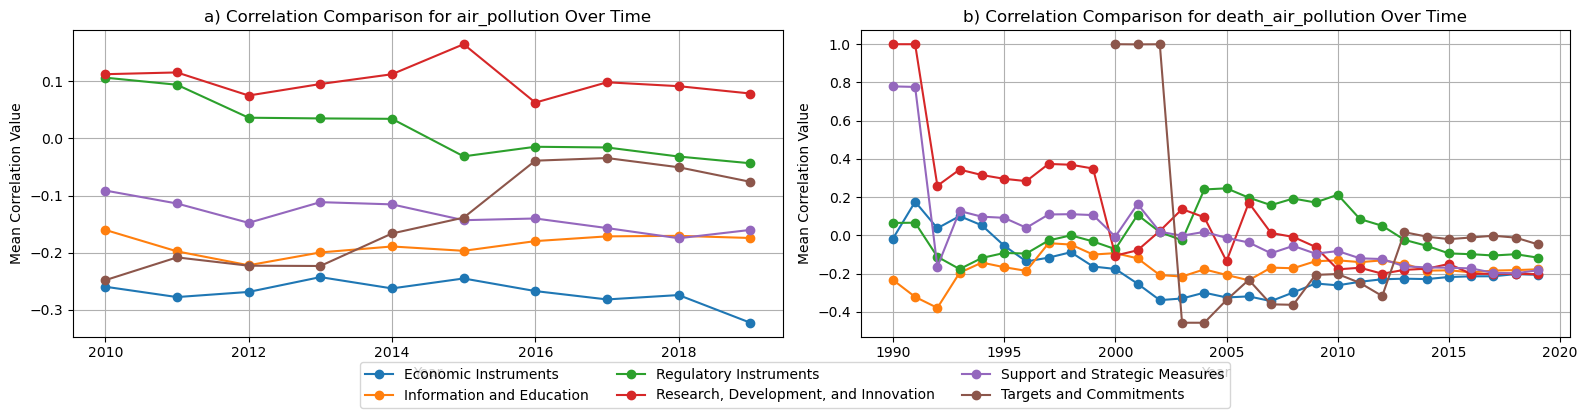

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get the unique graph names
unique_graph_names = [
    'air_pollution',
    'death_air_pollution'
]

# Determine the number of rows and columns for subplots
num_graphs = len(unique_graph_names)
cols = 2
rows = np.ceil(num_graphs / cols).astype(int)

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))

# Flatten axes array if there are multiple rows and columns
axes = axes.flatten() if rows * cols > 1 else [axes]

# To collect legend handles and labels
handles, labels = [], []

a = ['a', 'b']

# Iterate through each graph name and corresponding axis
for i, name in enumerate(unique_graph_names):
    ax = axes[i]  # Get the correct subplot axis

    # Plot each policy instrument within the current graph_name
    for instr in grouped['policy_instrument'].unique():
        subset = grouped[(grouped['graph_name'] == name) & (grouped['policy_instrument'] == instr)]
        if not subset.empty:
            line, = ax.plot(subset['year'], subset['correlation_value'], label=f"{instr}", marker='o')
            if instr not in labels:
                handles.append(line)
                labels.append(instr)
    
    # Add plot titles and labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Correlation Value')
    ax.set_title(f'{a[i]}) Correlation Comparison for {name} Over Time')
    ax.grid(True)
    
# Remove the last (empty) subplot if it exists
if len(axes) > num_graphs:
    fig.delaxes(axes[-1])

# Create a global legend at the bottom of the figure
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

# Save the combined figure to a file
fig.savefig('3_image/result_combine_3.png', dpi=300, bbox_inches='tight')

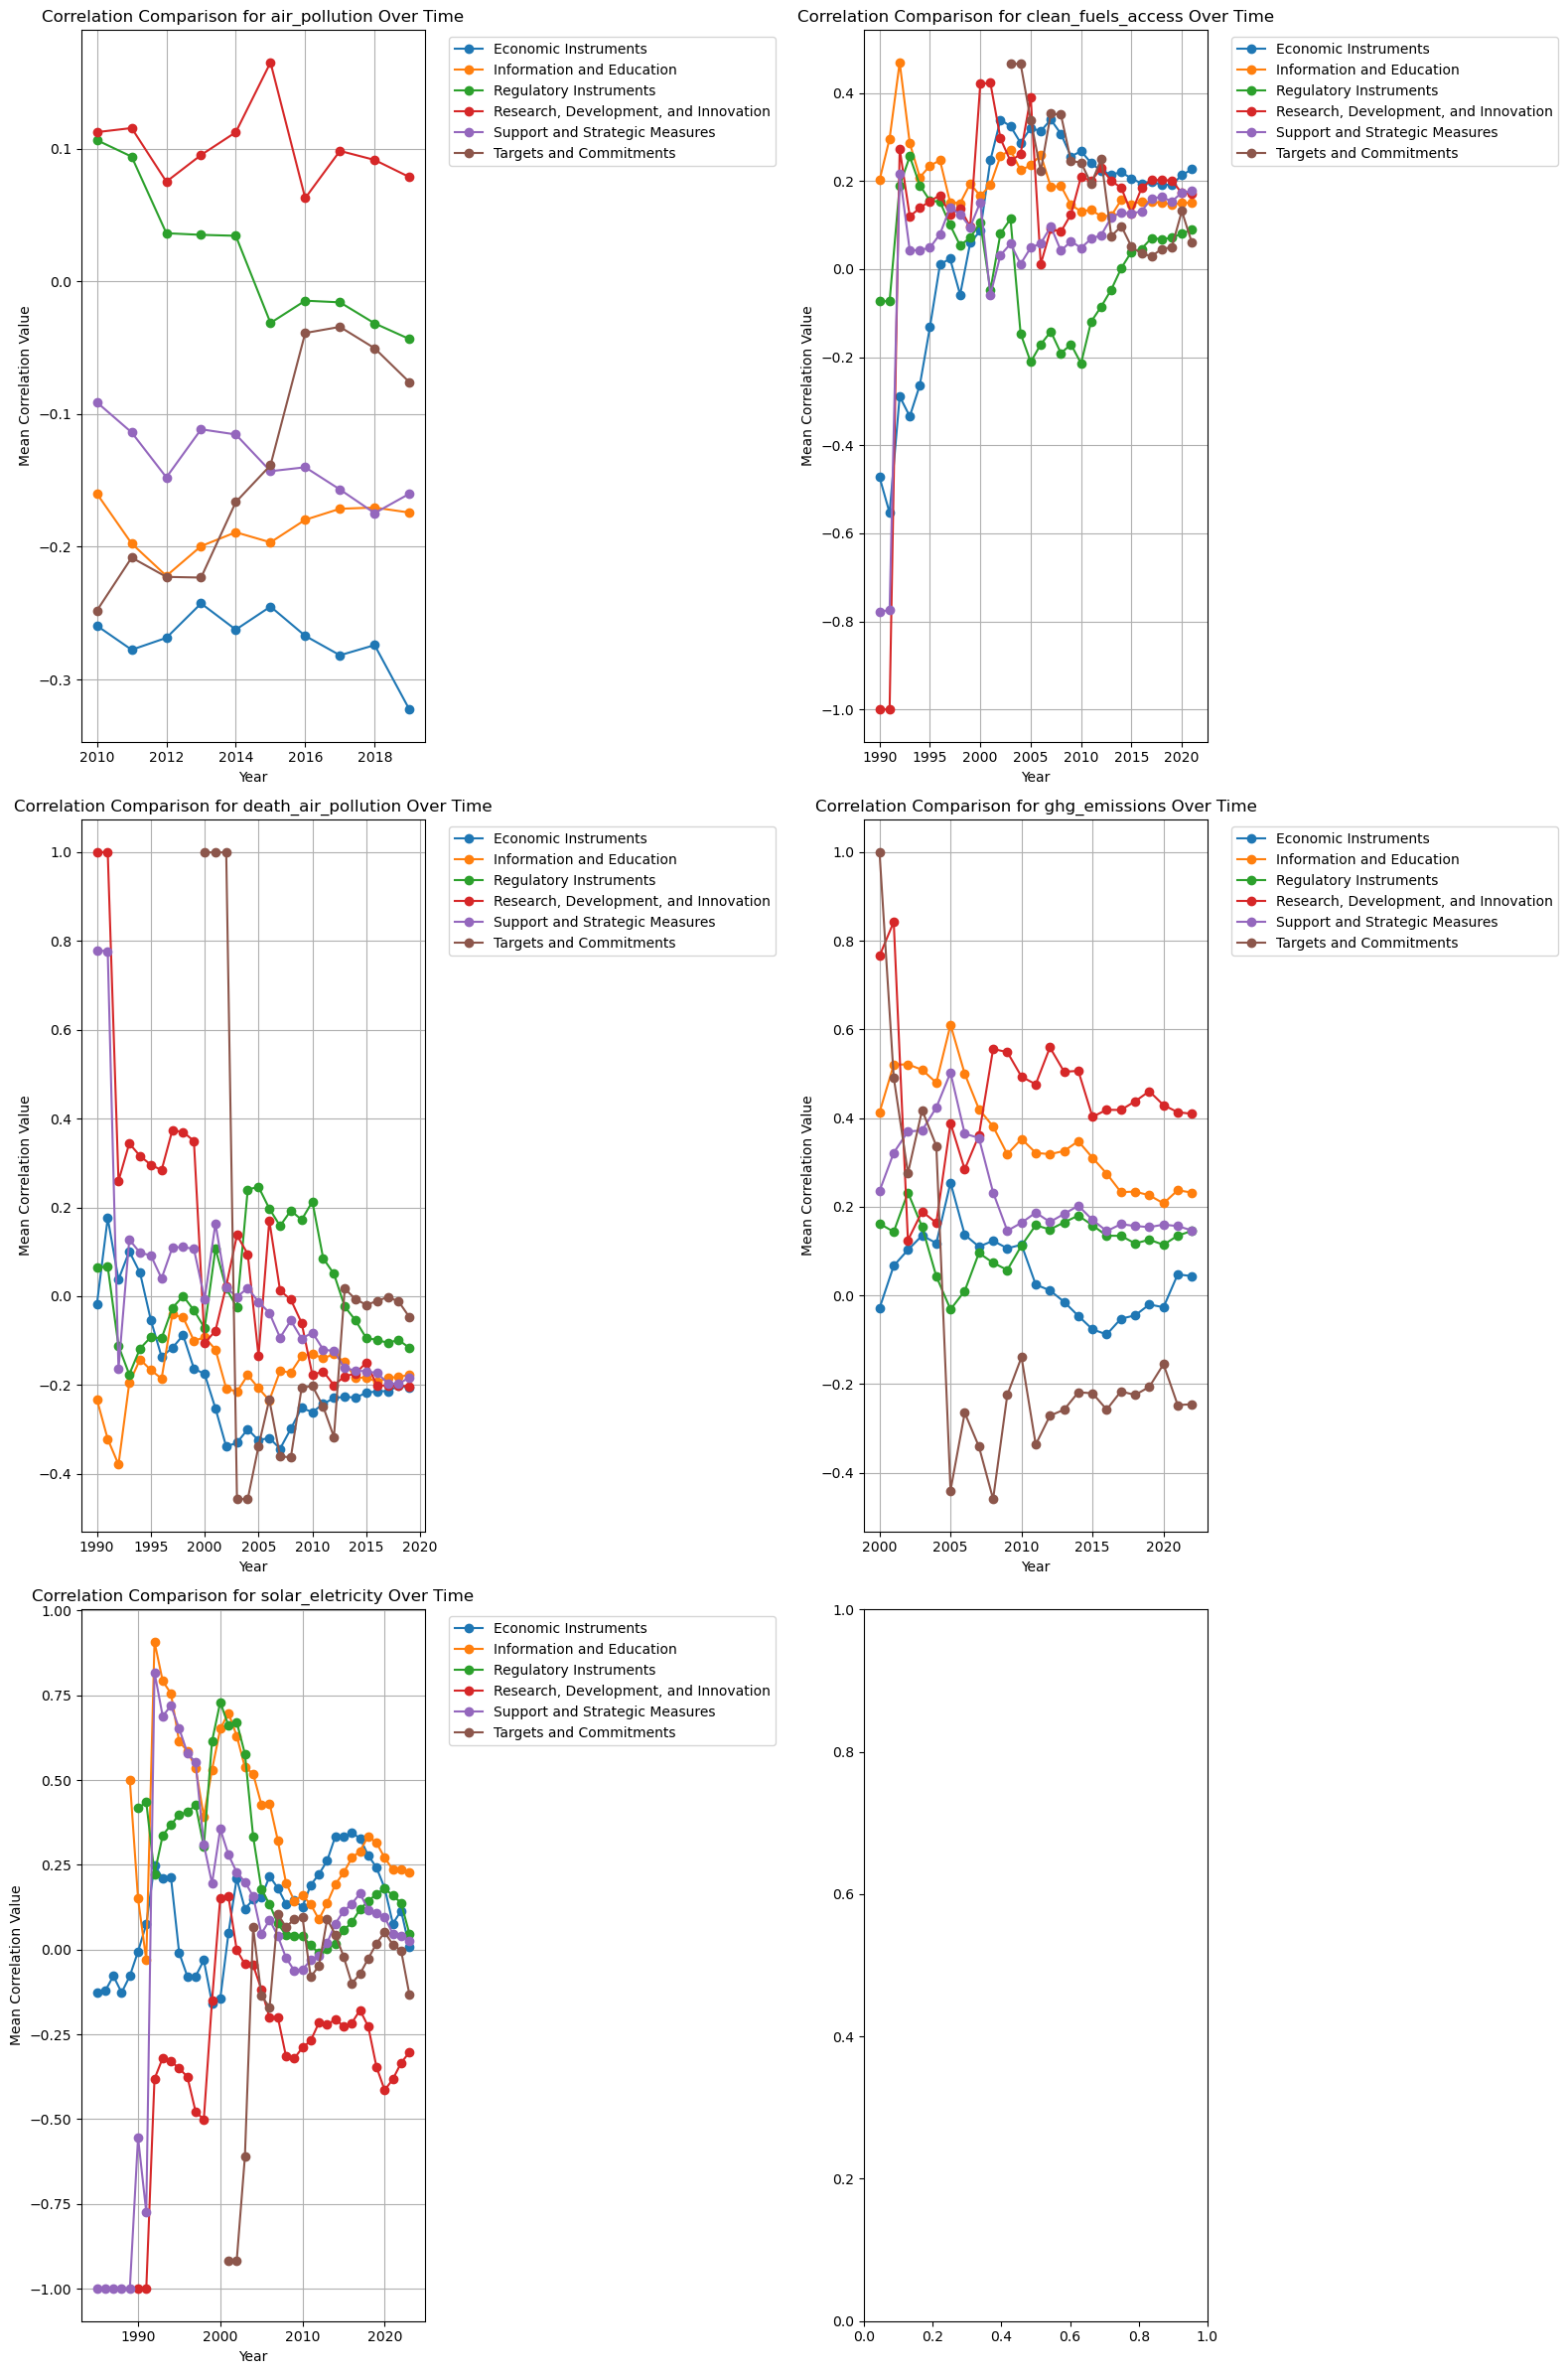

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get the unique graph names
unique_graph_names = grouped['graph_name'].unique()

# Determine the number of rows and columns for subplots
num_graphs = len(unique_graph_names)
cols = 2
rows = np.ceil(num_graphs / cols).astype(int)

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 8 * rows))

# Flatten axes array if there are multiple rows and columns
if rows * cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Iterate through each graph name and corresponding axis
for i, name in enumerate(unique_graph_names):
    ax = axes[i]  # Get the correct subplot axis

    # Plot each policy instrument within the current graph_name
    for instr in grouped['policy_instrument'].unique():
        subset = grouped[(grouped['graph_name'] == name) & (grouped['policy_instrument'] == instr)]
        if not subset.empty:
            ax.plot(subset['year'], subset['correlation_value'], label=f"{instr}", marker='o')
    
    # Add plot titles and labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Correlation Value')
    ax.set_title(f'Correlation Comparison for {name} Over Time')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

# Save the combined figure to a file
fig.savefig('3_image/combined_figure.png', dpi=300, bbox_inches='tight')

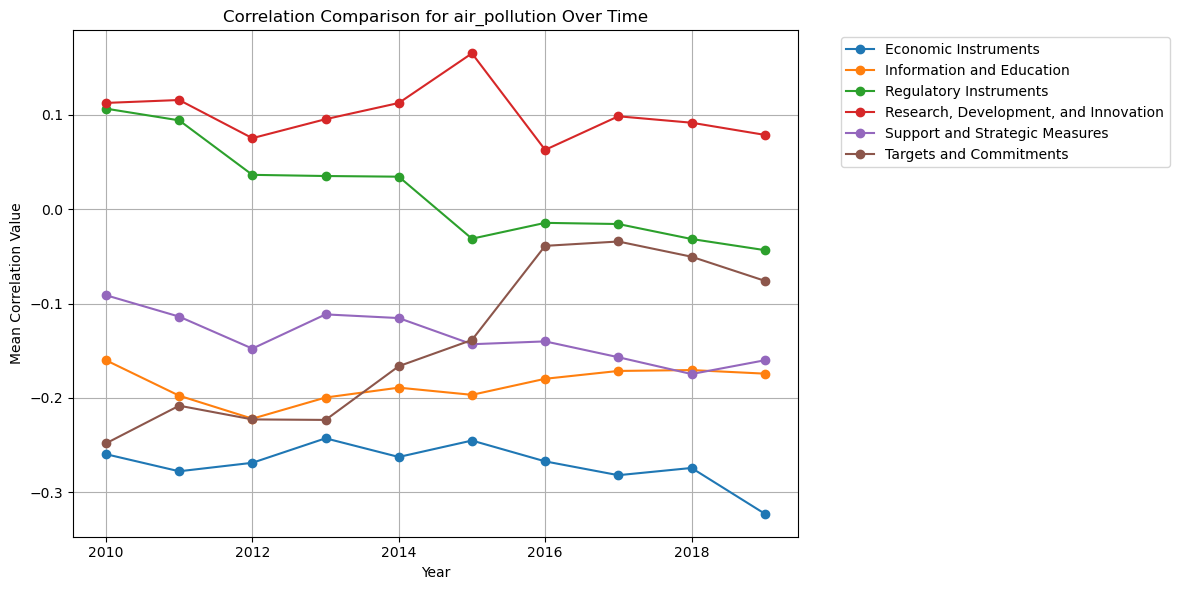

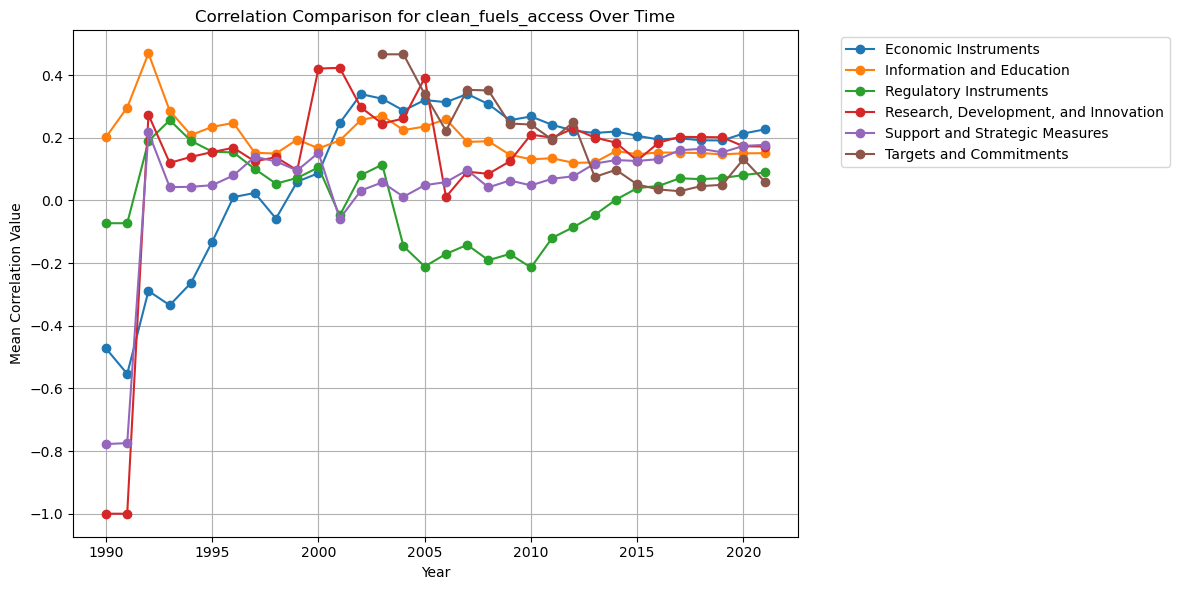

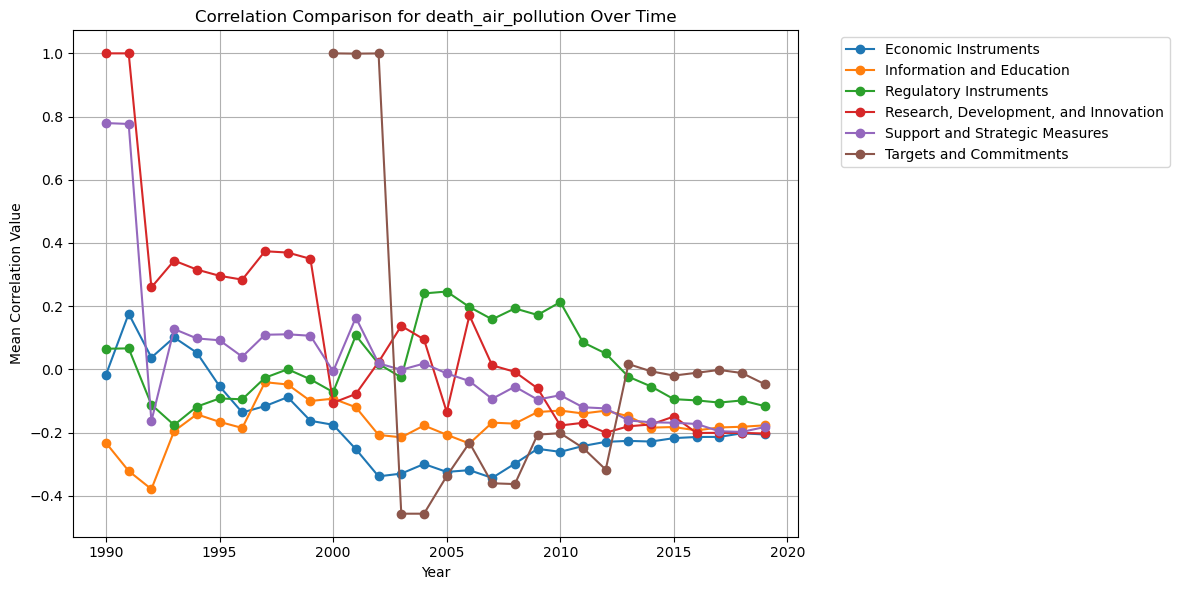

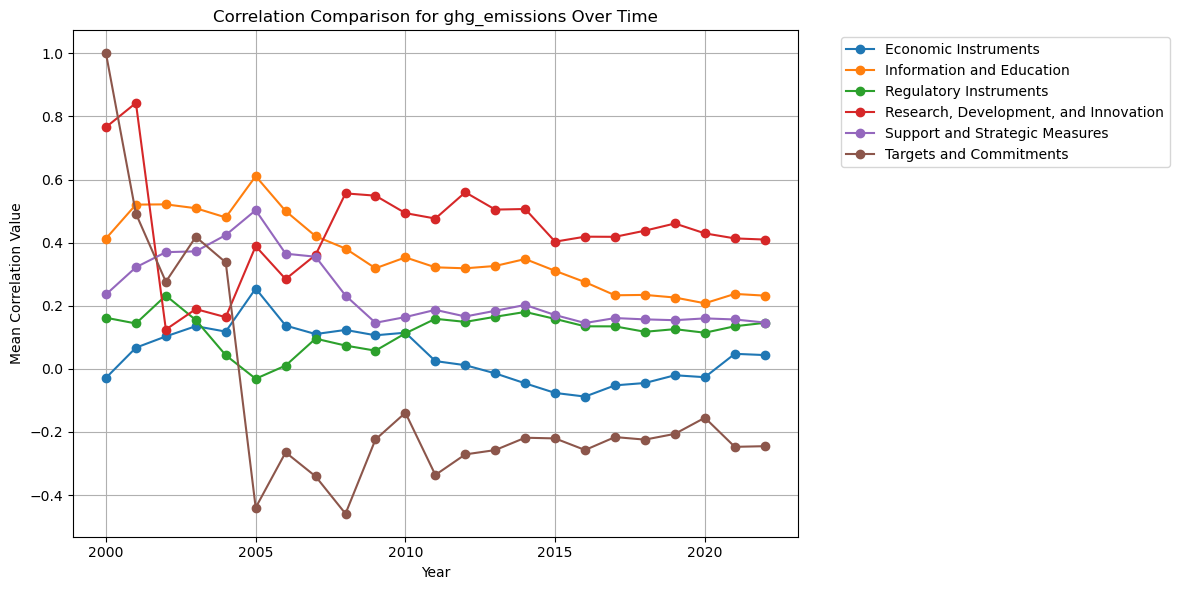

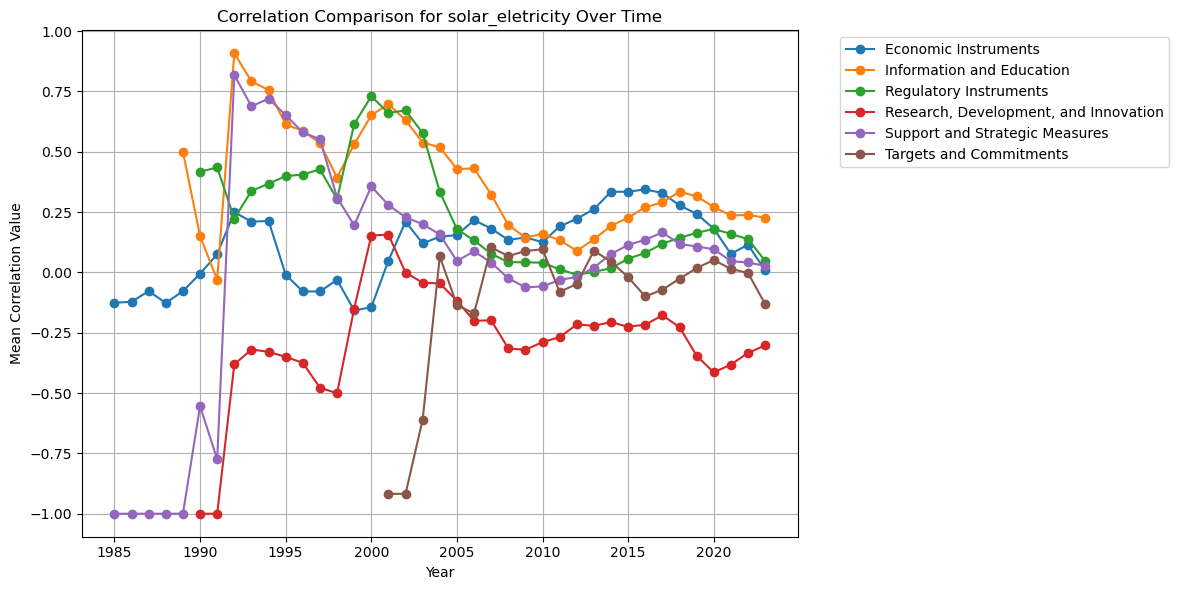

In [5]:
import matplotlib.pyplot as plt

# Create a figure for each graph_name
unique_graph_names = grouped['graph_name'].unique()

for name in unique_graph_names:
    plt.figure(figsize=(12, 6))
    
    # Plot each policy instrument within the current graph_name
    for instr in grouped['policy_instrument'].unique():
        subset = grouped[(grouped['graph_name'] == name) & (grouped['policy_instrument'] == instr)]
        if not subset.empty:
            plt.plot(subset['year'], subset['correlation_value'], label=f"{instr}", marker='o')
    
    # Add plot titles and labels
    plt.xlabel('Year')
    plt.ylabel('Mean Correlation Value')
    plt.title(f'Correlation Comparison for {name} Over Time')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.tight_layout()
    
    # Save the figure to a file
    plt.savefig(f'3_image/3_Correlation_Comparison_{name}.png', dpi=300, bbox_inches='tight')
    
    # Show the figure
    plt.show()

In [6]:
# Group the comparison results by Graph Name and Instruments for easier visualization
grouped_comparison = comparison_df.groupby(['Graph Name', 'Instrument 1', 'Instrument 2']).agg({
    'Z-Score Difference': 'mean',
    'P-Value': 'mean',
    'Adjusted P-Value': 'mean',
    'Significant': 'mean'
}).reset_index()

print("Grouped Comparison Results by Graph Name and Instruments:")
grouped_comparison

Grouped Comparison Results by Graph Name and Instruments:


,Graph Name,Instrument 1,Instrument 2,Z-Score Difference,P-Value,Adjusted P-Value,Significant
0,air_pollution,Economic Instruments,Information and Education,-1.737089,1.493347e-01,273.282481,0.000000
1,air_pollution,Economic Instruments,"Research, Development, and Innovation",-4.690573,7.520393e-06,0.013762,0.900000
2,air_pollution,Economic Instruments,Targets and Commitments,-2.150739,2.829143e-01,517.733220,0.100000
3,air_pollution,Regulatory Instruments,Economic Instruments,6.283125,1.799102e-07,0.000329,1.000000
4,air_pollution,Regulatory Instruments,Information and Education,4.269508,6.172620e-04,1.129589,0.500000
...,...,...,...,...,...,...,...
70,solar_eletricity,Support and Strategic Measures,Regulatory Instruments,-0.946156,2.120127e-01,387.983280,0.102564
71,solar_eletricity,Support and Strategic Measures,"Research, Development, and Innovation",4.296361,4.898231e-02,89.637636,0.323529
72,solar_eletricity,Support and Strategic Measures,Targets and Commitments,1.631618,2.668664e-01,488.365598,0.080000
73,solar_eletricity,Targets and Commitments,Information and Education,-3.980360,9.220799e-02,168.740620,0.360000


In [7]:
# Define desired correlation direction for each graph_name
desired_correlation_direction = {
    'fossil_production': 'lower',
    'ghg_emissions': 'lower',
    'nuclear_consumption': 'higher',
    'nuclear_production': 'higher',
    'primary_fossil_consumption': 'lower',
    'renewables_consumption': 'higher',
    'renewables_production_Electricity from hydro - TWh': 'higher',
    'renewables_production_Electricity from solar - TWh': 'higher',
    'renewables_production_Electricity from wind - TWh': 'higher',
    'renewables_production_Other renewables including bioenergy - TWh': 'higher'
}

# Create a summary DataFrame to store results
better_instruments_summary = []

for graph in comparison_df['Graph Name'].unique():
    graph_data = comparison_df[comparison_df['Graph Name'] == graph]
    
    # Dictionary to hold the score for each instrument
    instruments = set(graph_data['Instrument 1'].unique()).union(set(graph_data['Instrument 2'].unique()))
    instrument_scores = {instr: 0 for instr in instruments}
    
    # Determine the desired direction for the current graph_name
    desired_direction = desired_correlation_direction.get(graph)
    
    # Initialize variables to store the best instrument details
    best_instrument = None
    best_score = -float('inf')  # Start with a very low score
    best_z_diff = None
    best_p_value = None
    best_significant = None
    
    # Evaluate each pairwise comparison
    for _, row in graph_data.iterrows():
        instr1 = row['Instrument 1']
        instr2 = row['Instrument 2']
        z_diff = row['Z-Score Difference']
        significant = row['Significant']
        p_value = row['P-Value']
        
        if significant:  # Consider only significant differences
            if desired_direction == 'higher':
                # Higher correlation is better
                if z_diff > 0:
                    instrument_scores[instr1] += 1  # instr1 is better
                elif z_diff < 0:
                    instrument_scores[instr2] += 1  # instr2 is better
            elif desired_direction == 'lower':
                # Lower correlation is better
                if z_diff > 0:
                    instrument_scores[instr2] += 1  # instr2 is better
                elif z_diff < 0:
                    instrument_scores[instr1] += 1  # instr1 is better
        
        # Determine if this is the best instrument based on the score
        for instr, score in instrument_scores.items():
            if score > best_score:
                best_instrument = instr
                best_score = score
                best_z_diff = z_diff
                best_p_value = p_value
                best_significant = significant

    # Append the result for the current graph_name
    better_instruments_summary.append({
        'Graph Name': graph,
        'Best Instrument': best_instrument,
        'Score': best_score,
        'Z-Score Difference': best_z_diff,
        'P-Value': best_p_value,
        'Significant': best_significant
    })

# Convert the summary list to a DataFrame for better visualization
better_instruments_df = pd.DataFrame(better_instruments_summary)

# Display the summary
print("Summary of Best Instruments for Each Graph Name:")
better_instruments_df

Summary of Best Instruments for Each Graph Name:


,Graph Name,Best Instrument,Score,Z-Score Difference,P-Value,Significant
0,death_air_pollution,Economic Instruments,0,-4.262425,0.000020,True
1,clean_fuels_access,Economic Instruments,0,4.035301,0.000055,False
2,solar_eletricity,Economic Instruments,0,-0.618307,0.536373,False
3,ghg_emissions,Targets and Commitments,68,-8.403121,0.000000,True
4,air_pollution,Economic Instruments,0,-4.005040,0.000062,False


In [8]:
condensed_summary = []

for graph in better_instruments_df['Graph Name'].unique():
    graph_data = better_instruments_df[better_instruments_df['Graph Name'] == graph]
    
    # Find the best instrument by the highest score
    best_row = graph_data.loc[graph_data['Score'].idxmax()]
    
    condensed_summary.append({
        'Graph Name': graph,
        'Best Instrument': best_row['Best Instrument'],
        'Score': best_row['Score'],
        'Z-Score Difference': best_row['Z-Score Difference'],
        'P-Value': best_row['P-Value'],
        'Significant': best_row['Significant']
    })

# Convert to DataFrame
condensed_summary_df = pd.DataFrame(condensed_summary)

# Save or display the condensed summary
print("Condensed Summary of Effective Policy Instruments:")
condensed_summary_df.to_csv("3_image/condensed_summary.csv", index=False)
condensed_summary_df.head()

Condensed Summary of Effective Policy Instruments:


,Graph Name,Best Instrument,Score,Z-Score Difference,P-Value,Significant
0,death_air_pollution,Economic Instruments,0,-4.262425,0.000020,True
1,clean_fuels_access,Economic Instruments,0,4.035301,0.000055,False
2,solar_eletricity,Economic Instruments,0,-0.618307,0.536373,False
3,ghg_emissions,Targets and Commitments,68,-8.403121,0.000000,True
4,air_pollution,Economic Instruments,0,-4.005040,0.000062,False
